In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from nltk.tokenize import word_tokenize
import os
from pathlib import Path
import string

In [2]:
os.chdir('../')

In [3]:
%pwd

'c:\\Users\\Gautam\\Desktop\\project_of_ds_and_ml\\codesoft\\sms_spam_detection'

# Loading Data for the EDA

In [4]:
data_path=Path("artifacts/data_ingestion/data/spam.csv")
print(data_path)
df = pd.read_csv(data_path, encoding="latin-1")

df.head()

artifacts\data_ingestion\data\spam.csv


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.dropna(axis=1, inplace=True)

In [6]:
df.columns = ['target', 'sms_message']

In [7]:
df.head()

,target,sms_message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: xlabel='target', ylabel='count'>

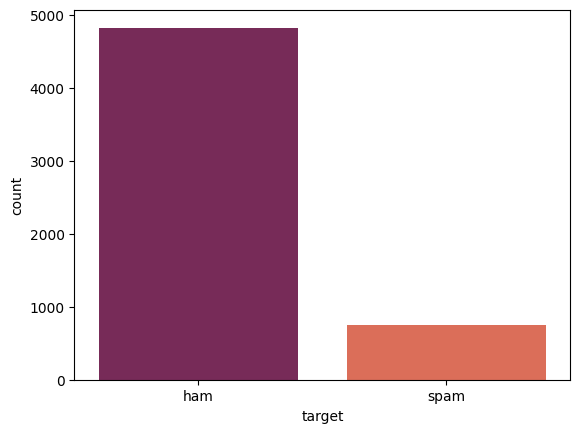

In [8]:
sns.countplot(x = 'target',data = df, palette="rocket")

#### Here we can conclude that there is an imbalance in data.

In [9]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]\n', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [10]:
def remove_stopwords(text):
    stop_words = nltk.corpus.stopwords.words('english')
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [11]:
def stemm_text(text):
    stemmer = nltk.SnowballStemmer("english")
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [12]:
def preprocess_data(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = stemm_text(text)
    
    return text

In [13]:
df['processed_message'] = df['sms_message'].apply(preprocess_data)
df.head()

,target,sms_message,processed_message
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


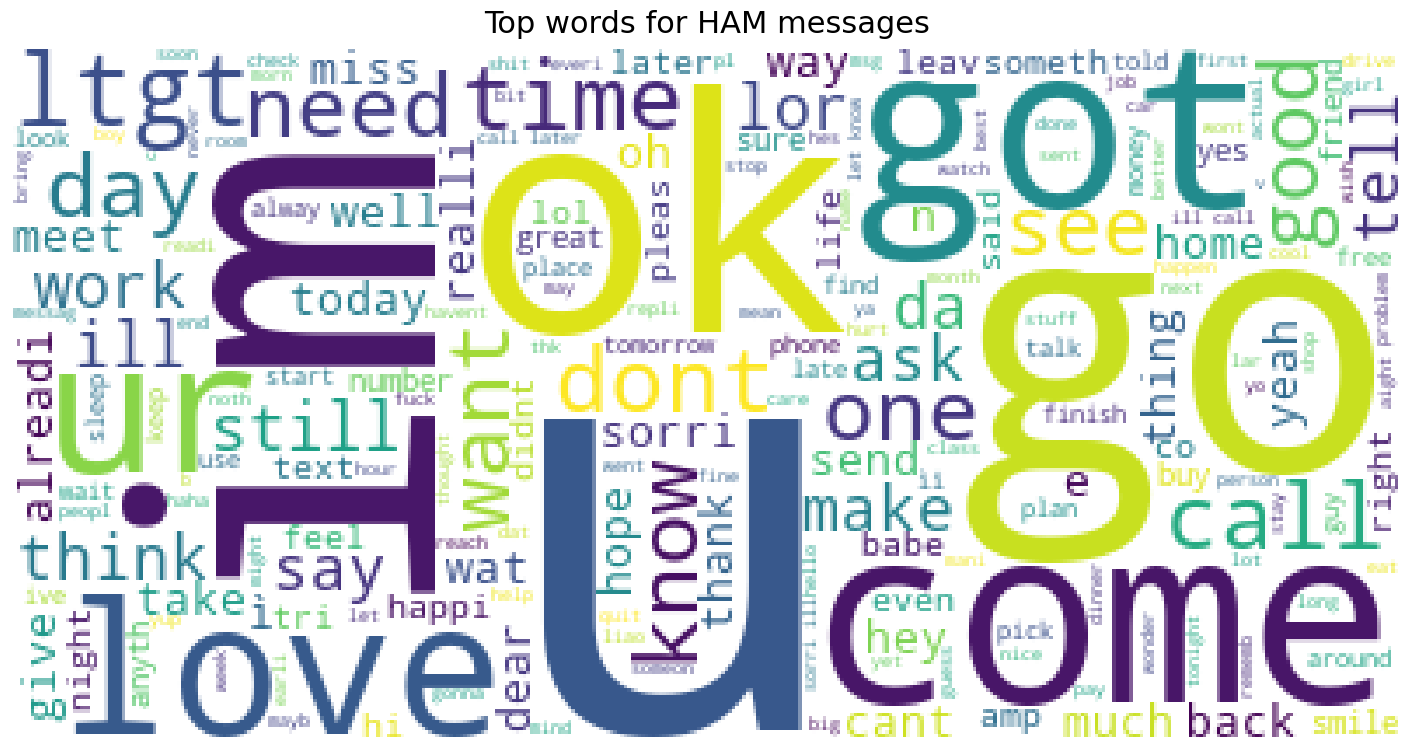

In [14]:
from wordcloud import WordCloud
wc = WordCloud(
    background_color='white', 
    max_words=200
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'ham', 'processed_message']))
plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

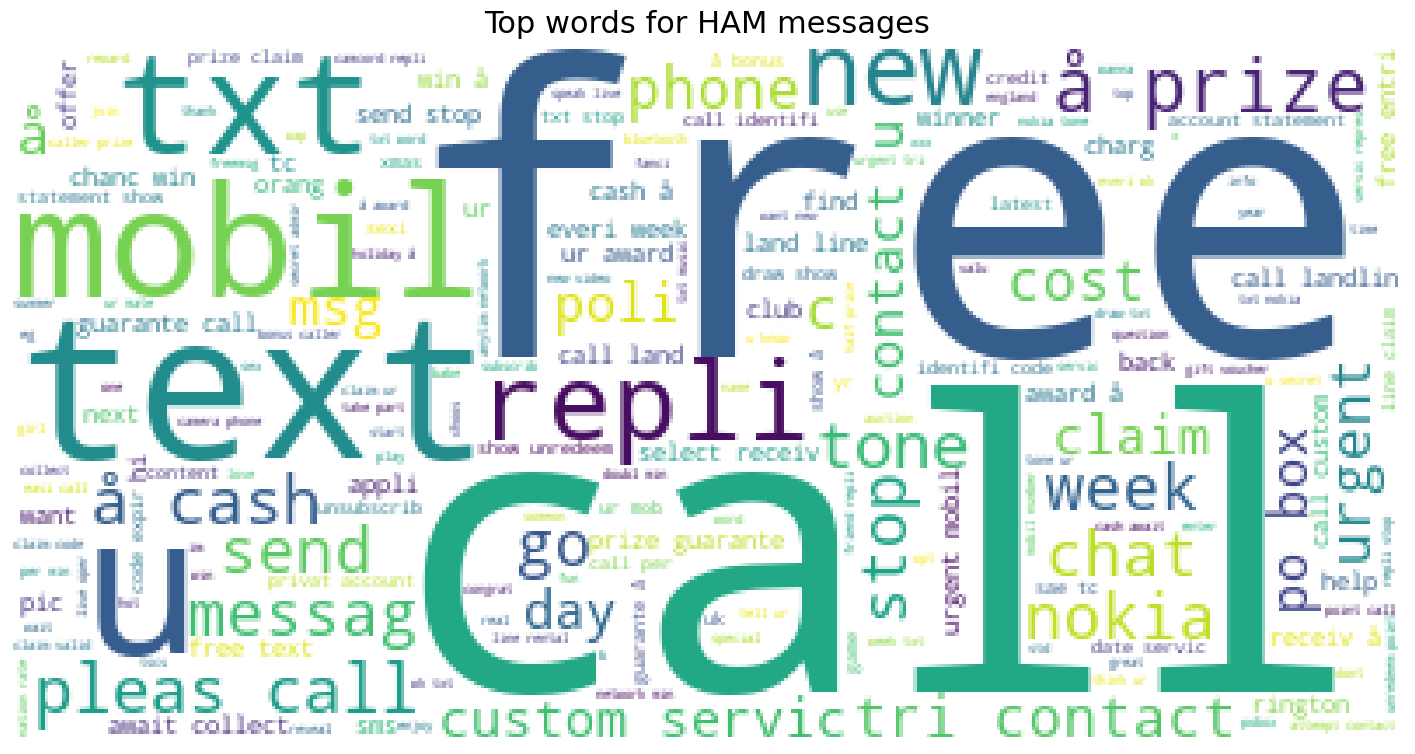

In [15]:
wc = WordCloud(
    background_color='white', 
    max_words=200
)
wc.generate(' '.join(text for text in df.loc[df['target'] == 'spam', 'processed_message']))
plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])

In [17]:
x = df['processed_message']
y = df['target_encoded']

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [20]:
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

x_train_tfidf, x_test_tfidf

(<4179x5718 sparse matrix of type '<class 'numpy.float64'>'
 	with 32747 stored elements in Compressed Sparse Row format>,
 <1393x5718 sparse matrix of type '<class 'numpy.float64'>'
 	with 10091 stored elements in Compressed Sparse Row format>)

In [22]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
x_train_tfidf, y_train = sm.fit_resample(x_train_tfidf, y_train)
x_test_tfidf, y_test = sm.fit_resample(x_test_tfidf, y_test)

In [23]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [24]:
%time nb.fit(x_train_tfidf, y_train)

CPU times: total: 0 ns
Wall time: 4.01 ms


MultinomialNB()

In [25]:
from sklearn import metrics

# make class predictions for X_test_dtm
y_pred_class = nb.predict(x_test_tfidf)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test, y_pred_class)

=======Accuracy Score===========
0.9550748752079867
=======Confision Matrix===========


array([[1160,   42],
       [  66, 1136]], dtype=int64)

In [27]:
from sklearn.svm import SVC

svc=SVC()
svc.fit(x_train_tfidf, y_train)

SVC()

In [28]:
y_pred_class = svc.predict(x_test_tfidf)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test, y_pred_class)

=======Accuracy Score===========
0.910981697171381
=======Confision Matrix===========


array([[1200,    2],
       [ 212,  990]], dtype=int64)

In [30]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear')

# train the model using X_train_dtm
logreg.fit(x_train_tfidf, y_train)

LogisticRegression(solver='liblinear')

In [31]:
y_pred_class = logreg.predict(x_test_tfidf)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_class))

# print the confusion matrix
print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test, y_pred_class)

=======Accuracy Score===========
0.8935108153078203
=======Confision Matrix===========


array([[1187,   15],
       [ 241,  961]], dtype=int64)